In [1]:
# Regular Modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.special as sc
import scipy.sparse as sps
import datetime

# My Modules
import src.helpers as helpers
import src.model_systems as model_systems
import src.diffusion_map as dmap

# Use timestamp for saving
time = datetime.datetime.now().strftime("%Y_%m%d_%H%M%S")
%matplotlib inline
plt.rcParams['figure.dpi'] = 75 # default is 75
plt.style.use('default')


## Set up System, Plot Potential and Diffusion

grid minimum is: 0
grid maximum is: 50


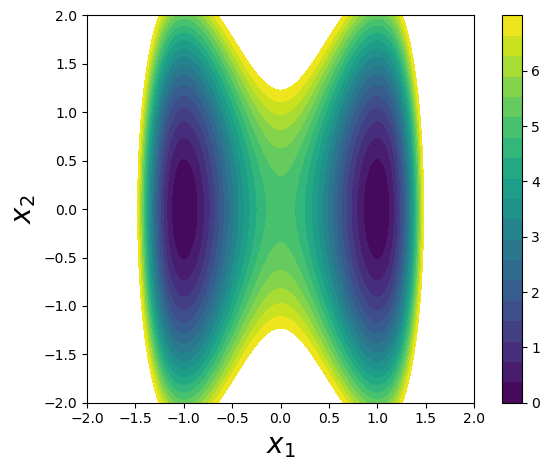

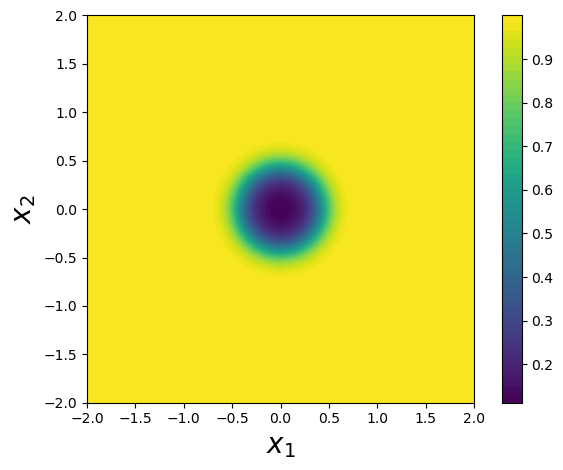

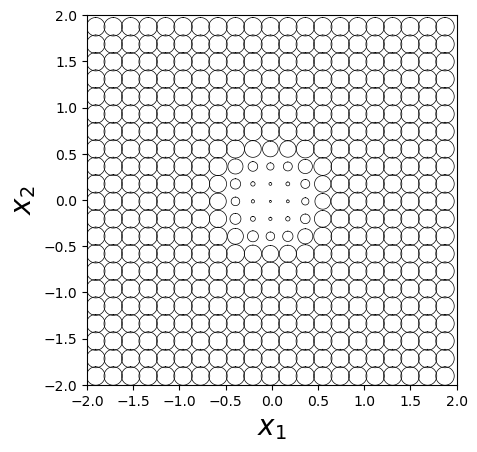

In [2]:
# Setting inverse temperature for plotting
beta = 1.0

def potential(x): return model_systems.morocardin_potential(x)
def magn_diffusion(x): return np.linalg.norm(model_systems.morocardin_sqrt_diffusion(x)[0,0]**2)

xmin, xmax = -2, 2
ymin, ymax = -2, 2
nx, ny = 128, 128
volume = (xmax - xmin)*(ymax - ymin)

# Plot potential on a mesh
plt.figure()
plot_params = [nx, ny, xmin, xmax, ymin, ymax]
[potential_grid, xx, yy] = helpers.gen_plot_data(potential, plot_params)
grid_min = np.min(potential_grid)
grid_max = np.max(potential_grid)
print("grid minimum is: %d" % grid_min)
print("grid maximum is: %d" % grid_max)
contour_levels = np.linspace(0, 7, 20)
plt.contourf(xx, yy, potential_grid, levels=contour_levels)

C = plt.colorbar()
C.set_ticks(np.arange(0, 7, 1))
C.set_ticklabels(np.arange(0, 7, 1))

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.title("Potential")
#plt.savefig("figures/morocardin_potential.png", dpi=300)

# Plot sampling of diffusion tensors
plt.figure() 
plot_params = [nx, ny, xmin, xmax, ymin, ymax]
[magn_grid, xx, yy] = helpers.gen_plot_data(magn_diffusion, plot_params)
grid_min = np.amin(magn_grid)
grid_max = np.amax(magn_grid)
contour_levels = np.linspace(grid_min, grid_max, 50)
plt.contourf(xx, yy, magn_grid, levels=contour_levels)

C = plt.colorbar()
C.set_ticks(np.around(np.arange(0.2, 1, 0.1), decimals=1))
C.set_ticklabels(np.around(np.arange(0.2, 1, 0.1), decimals=1))

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

#plt.savefig("figures/morocardin_magn_diffusion.png", dpi=300)

plt.figure()
for j in range(3, nx-1, 6):
    for i in range(3, ny-1, 6):
        val = np.zeros(2)
        val[0] = xx[i, j]
        val[1] = yy[i, j]
        C = model_systems.morocardin_sqrt_diffusion(val)**2
        helpers.plot_cov_ellipse(C, val, plot_scale=0.1)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.gca().set_aspect('equal', adjustable='box')
#plt.axis("equal")
#plt.savefig("figures/morocardin_diffusion_tensors.png", dpi=300)



# Load Data for Diffusion Maps

In [3]:
# betainv3: trajectory from high temperature
# metad: trajectory from well-tempered metadynamics
# deltanet: a large metad trajectory pruned to be uniform

datasets = ['betainv3', 'deltanet', 'metad']
methods = ['MMAP', 'DMAP', 'targetMMAP', 'targetDMAP']

dataset = datasets[2]
method = methods[2]

# Trajectory data
fname = f"systems/MoroCardin/data/data_solution_{dataset}.npz"
inData = np.load(fname)
data = inData['data']
diffusion_list = inData['diffusion_list']

N = data.shape[1]
print(f"data dimensions: {data.shape}")

data dimensions: (2, 10000)


## Set Reactant, Product Sets for Committor

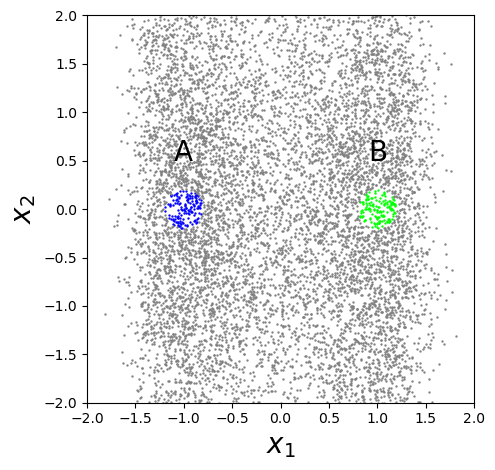

In [4]:
# Create boolean arrays defining A,B and rest of the domain (C)
A_bool = np.zeros(N, dtype=bool)
B_bool = np.zeros(N, dtype=bool)

# For setting, A,B based on circles
center_A = np.array([-1, 0])
center_B = np.array([1, -0])
radius_A = 0.2
radius_B = 0.2

dist_A = np.sqrt(np.sum((center_A[..., np.newaxis] - data)**2, axis=0))
dist_B = np.sqrt(np.sum((center_B[..., np.newaxis] - data)**2, axis=0))
A_bool = dist_A < radius_A
B_bool = dist_B < radius_B 
C_bool = ~np.logical_or(A_bool, B_bool)

A_plot = data[:, A_bool]
B_plot= data[:, B_bool]
C_plot = data[:, C_bool]

my_cmap = matplotlib.cm.get_cmap('brg')
A_color= my_cmap(0.0)
B_color = my_cmap(1.0)

fig = plt.figure() 
plt.scatter(A_plot[0, :], A_plot[1, :], s=0.5, color=A_color)
plt.scatter(B_plot[0, :], B_plot[1, :], s=0.5, color=B_color)
plt.scatter(C_plot[0, :], C_plot[1, :], s=0.5, color='gray')
plt.gca().text(-1.1, 0.5, 'A', fontsize=20)
plt.gca().text(0.9, 0.5, 'B', fontsize=20)

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig(f"figures/reactant_product_{dataset}.png", dpi=300)
#plt.show()



## Compute a Diffusion Map

In [5]:
eps = 0.0038
neigh_mode = "RNN"  # setting to radius nearest neighbors for kernel
radius = None  # defaults to setting the radius based on eps
n_neigh = 512 # for choosing neigh_mode = "KNN," k-nearest neighbors

# Compute target measure
target_beta = 1
target_measure = np.zeros(N)
for i in range(N):
    target_measure[i] = np.exp(-target_beta*potential(data[:, i]))

##### Compute some sort of diffusion map 
if method == 'MMAP' or method == 'targetMMAP':
    if method == 'MMAP':
        target_measure = None
    my_dmap = dmap.TargetMeasureMahalanobisDiffusionMap(epsilon=eps, diffusion_list=diffusion_list, 
                                                       radius=radius, n_neigh=n_neigh, neigh_mode=neigh_mode,
                                                       target_measure=target_measure, 
                                                       remove_isolated=True, pbc_dims=None)

if method == 'DMAP' or method =='targetDMAP':
    if method == 'DMAP':
        target_measure = None
    my_dmap = dmap.TargetMeasureDiffusionMap(epsilon=eps, radius=radius, n_neigh=n_neigh, 
                                             neigh_mode=neigh_mode, 
                                             target_measure=target_measure, 
                                             remove_isolated=True, pbc_dims=None)

my_dmap.construct_generator(data)


q, subgraph  = my_dmap.construct_committor(B_bool, C_bool)
L = my_dmap.get_generator()

# with radius nearest neighbors, some data points may be discarded, so we take the non-isolated ones
nonisolated_bool = subgraph["nonisolated_bool"] 
data_nonisolated = data[:, nonisolated_bool]



Computing Mahalanobis distance
computing RNN kernel
nodes left after removing isolated: 10000
ratio of nonzeros: 0.03594944


### Compute Normalizing Constant

In [6]:
N = L.shape[0]

if method == 'targetMMAP':
    sqdists = my_dmap._compute_sqdists(data_nonisolated, metric=None)
else:
    sqdists = my_dmap._compute_sqdists(data_nonisolated)

fname = f"systems/MoroCardin/data/Ktest_{dataset}_kde.npz"
inData = np.load(fname) 
optimal_kde_eps = inData["optimal_eps"]

kde = np.sum(np.exp(-sqdists/(2*eps)), axis=1) 
kde = kde*(N*2*np.pi*eps)**(-1)

target_measure_noniso = target_measure[nonisolated_bool]
Z_dmap = (1/N)*np.sum(target_measure_noniso / kde)
print(f"approximate Z via dmaps: {Z_dmap}")


approximate Z via dmaps: 1.2625321077937899


# Plot Committors

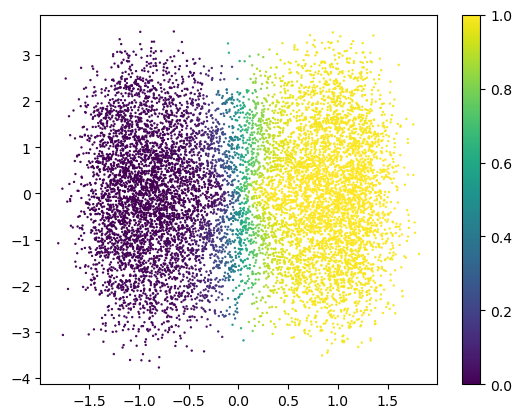

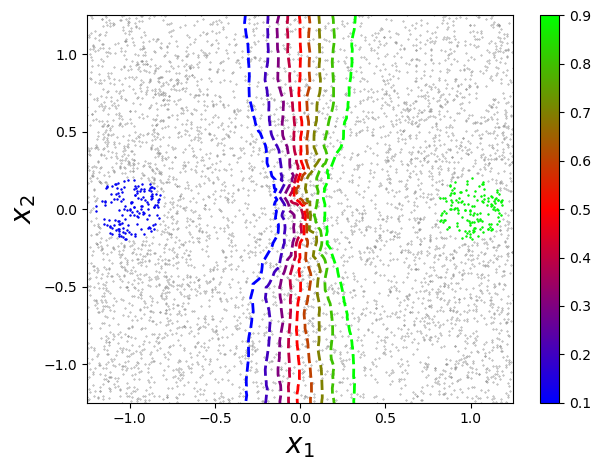

In [7]:
triang = tri.Triangulation(data_nonisolated[0, :], data_nonisolated[1, : ])

fig = plt.figure()
plt.scatter(data_nonisolated[0, :], data_nonisolated[1, :], s=0.5, c=q)
plt.colorbar()

fig = plt.figure()
plt.scatter(data_nonisolated[0, :], data_nonisolated[1, :], s=0.1, color='gray')
my_levels = helpers.committor_contours()
cmap = 'brg'
C1=plt.tricontour(triang, q, levels=my_levels, linewidths=2.0, linestyles='dashed', cmap=cmap)
norm= matplotlib.colors.Normalize(vmin=C1.cvalues.min(), vmax=C1.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = C1.cmap)
sm.set_array([])
fig.colorbar(sm, ticks=C1.levels)

my_cmap = matplotlib.cm.get_cmap('brg')
A_color= my_cmap(0.0)
B_color = my_cmap(1.0)

plt.scatter(A_plot[0, :], A_plot[1, :], s=0.5, color=A_color)
plt.scatter(B_plot[0, :], B_plot[1, :], s=0.5, color=B_color)
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
plt.tight_layout()

#plt.title(f'Interpolated FEM solution, committor contour') 
#plt.savefig(f"figures/committor_contours_{method}_{dataset}.png", dpi=300)


# Reactive Currents

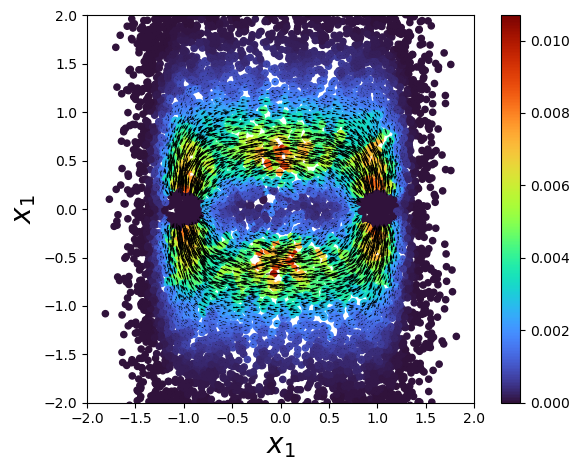

In [8]:
# Compute Reactive Current
if sps.issparse(L):
    L = L.toarray()
current_x = target_measure[nonisolated_bool]*helpers.duchamp(L, q, data_nonisolated[0, :])
current_y = target_measure[nonisolated_bool]*helpers.duchamp(L, q, data_nonisolated[1, :])
current = np.vstack([current_x, current_y])

# Current isn't defined on A or B
A_bool_nonisolated = A_bool[nonisolated_bool]
B_bool_nonisolated = B_bool[nonisolated_bool]
C_bool_nonisolated = C_bool[nonisolated_bool]
current[:, A_bool_nonisolated] = 0
current[:, B_bool_nonisolated] = 0

# Define magnitude, define new array for (potentially) subsampling
curr_mag = np.sqrt(current[0, :]**2 + current[1, :]**2)

plt.figure() 
cmap = 'turbo'
plt.scatter(data_nonisolated[0, :], data_nonisolated[1, :], s=20.0, c=curr_mag, cmap=cmap)
plt.colorbar()
#plt.quiver(data_nonisolated[0, :], data_nonisolated[1, :], current[0, :], current[1, :], angles='xy', scale_units='xy', width=0.0015, minlength=0, pivot='mid')
plt.quiver(data_nonisolated[0, :], data_nonisolated[1, :], current[0, :], current[1, :], angles='xy', scale=0.25, minlength=0, headwidth=2, pivot='mid')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_1$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

